In [252]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib_inline.backend_inline

from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.metrics import confusion_matrix, classification_report, \
    PrecisionRecallDisplay, RocCurveDisplay, accuracy_score

In [181]:
matplotlib_inline.backend_inline.set_matplotlib_formats('png', 'pdf')
plt.rcParams.update({'font.size': 12,
                     'xtick.labelsize' : 12,
                     'ytick.labelsize' : 12,
                     'axes.grid': False})

my_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [182]:
def plot_confusion_mtx(cm: 'confusion matrix', labels = None, 
                       figsize = (3,3), binary = True):
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot()
    sns.heatmap(cm, annot = True, fmt = '0', annot_kws = {"fontsize": 16}, 
                cmap = "Blues", cbar = False, ax = ax)
    ax.set_xlabel('Predicted Class', fontsize = 14)
    ax.set_ylabel('Actual Class', fontsize = 14)
    if labels is None:
        labels = range(1, cm.shape[1] + 1)     
    ax.set_xticks(ax.get_xticks(), labels)
    ax.set_yticks(ax.get_yticks(), labels)
    if binary:
        ax.set_xticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
        ax.set_yticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')

In [183]:
def plot_lift(y_true:'np array', y_pred_proba:'np array', 
              label = None, baseline = False):
    n_samples = len(y_true)
    idx = np.argsort(y_pred_proba)[::-1]
    cum_trues = list(accumulate(y_true[idx]))
    perc_trues = map(lambda x: x / cum_trues[-1], cum_trues)   
    cum_samples = range(1, n_samples + 1)
    perc_samples = map(lambda x: x / n_samples, cum_samples)  
    lift = list(map(lambda x, y: x / y, perc_trues, perc_samples))    
    plt.plot(lift, label = label)
    if baseline:
        plt.axhline(y = 1, ls = '--', color = 'k')
    plt.xlabel('% of samples', fontsize = 16)
    plt.ylabel('Lift', fontsize = 16)

In [184]:
def plot_gains_curve(y_true:'np array', y_pred_proba:'np array', 
                     label = None, baseline = False):
    idx = np.argsort(y_pred_proba)[::-1]
    acc = list(accumulate(y_true[idx]))
    plt.plot(acc, label = label)
    n_samples = len(acc)
    if baseline:
        plt.plot([0,n_samples], [0, acc[-1]], 'k--')
    
    xticks = np.linspace(0, n_samples, 6)
    yticks = np.linspace(0, acc[-1], 6)
    x_lab = np.around(np.linspace(0, 1, 6), decimals = 1) 
    y_lab = np.around(np.linspace(0, 1, 6), decimals = 1) 
    plt.xticks(xticks, x_lab)
    plt.yticks(yticks, y_lab)
    plt.xlabel('% of samples', fontsize = 16)
    plt.ylabel('Gain', fontsize = 16)

In [185]:
# Credits to prof. R. Guidotti

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

---

# Data Preparation

In [186]:
# we use the dataset without duplicated columns

X_train = pd.read_csv(r'old datasets\X_train_wo_outliers_num.csv', header = 0, index_col = 0)
y_train = pd.read_csv("y_train_wo_outliers_num.csv", header = None)[0]
X_test = pd.read_csv(r'old datasets\X_test_no_red.csv', header = 0)
y_test = pd.read_fwf('y_test.txt', header = None)[0]

In [187]:
X_train.columns = X_train.columns.astype(int)
X_test.columns = X_test.columns.astype(int)

In [188]:
X_train.shape, y_train.shape

((7274, 540), (7274,))

In [189]:
X_test.shape, y_test.shape

((2947, 540), (2947,))

In [190]:
with open("features.txt") as f:
    lines = f.read().splitlines() 

features = {}
for line in lines:
    idx, name = line.split()
    features[int(idx)-1] = name
    
# features

In [191]:
with open('activity_labels.txt') as f:
    lines = f.read().splitlines()

activities = {}
for line in lines:
    label, activity = line.split()
    activities[int(label)] = activity

In [192]:
activities

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

# Decision Tree

## w/o tuning

In [193]:
dtc = DTC(random_state = 5).fit(X_train, y_train)

In [194]:
dtc.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 5,
 'splitter': 'best'}

In [195]:
dtc.get_depth()

18

In [196]:
dtc.get_n_leaves()

162

In [197]:
y_pred = dtc.predict(X_test)

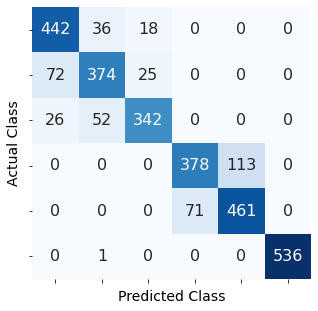

In [198]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_mtx(cm, [], binary = False, figsize = (5,5))

In [199]:
print(classification_report(y_test, y_pred, target_names = activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.82      0.89      0.85       496
  WALKING_UPSTAIRS       0.81      0.79      0.80       471
WALKING_DOWNSTAIRS       0.89      0.81      0.85       420
           SITTING       0.84      0.77      0.80       491
          STANDING       0.80      0.87      0.83       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.86      2947
         macro avg       0.86      0.86      0.86      2947
      weighted avg       0.86      0.86      0.86      2947



In [200]:
dtc_accuracy = accuracy_score(y_test, y_pred)
dtc_accuracy

0.8595181540549711

---

## w tuning

In [201]:
param = {'max_depth': list(range(3,11)),
         'min_samples_leaf': list(range(25,61, 5)),
         'max_leaf_nodes': list(range(10, 51, 5))}

grid_search = GridSearchCV(DTC(random_state = 5), 
                           param_grid = param, cv = 5,
                           n_jobs = -1,
                           scoring = 'accuracy')

In [202]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=5), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'max_leaf_nodes': [10, 15, 20, 25, 30, 35, 40, 45, 50],
                         'min_samples_leaf': [25, 30, 35, 40, 45, 50, 55, 60]},
             scoring='accuracy')

In [203]:
dtc_tuned = grid_search.best_estimator_

In [204]:
dtc_tuned.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': 15,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 25,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 5,
 'splitter': 'best'}

In [205]:
dtc_tuned.get_depth()

6

In [206]:
dtc_tuned.get_n_leaves()

15

In [207]:
y_pred = dtc_tuned.predict(X_test)

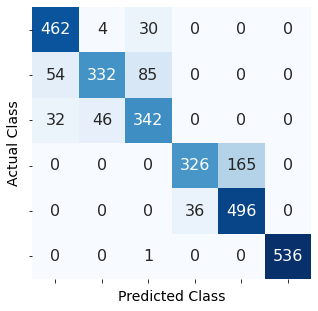

In [208]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_mtx(cm, [], binary = False, figsize = (5,5))

In [209]:
print(classification_report(y_test, y_pred, target_names = activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.84      0.93      0.89       496
  WALKING_UPSTAIRS       0.87      0.70      0.78       471
WALKING_DOWNSTAIRS       0.75      0.81      0.78       420
           SITTING       0.90      0.66      0.76       491
          STANDING       0.75      0.93      0.83       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.85      2947
         macro avg       0.85      0.84      0.84      2947
      weighted avg       0.85      0.85      0.84      2947



In [210]:
dtc_tuned_accuracy = accuracy_score(y_test, y_pred)
dtc_tuned_accuracy

0.846284356973193

In [211]:
# Mean cross-validated score of the best_estimator

grid_search.best_score_

0.8700857924814589

---

# KNN

## w/o tuning

In [212]:
knn = KNN(n_jobs = -1).fit(X_train, y_train)

In [213]:
y_pred = knn.predict(X_test)

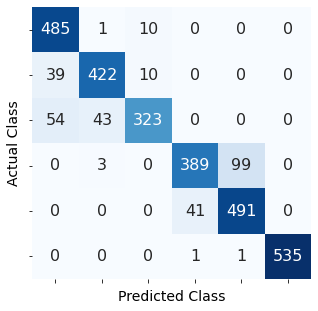

In [214]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_mtx(cm, [], binary = False, figsize = (5,5))

In [215]:
print(classification_report(y_test, y_pred, target_names = activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.84      0.98      0.90       496
  WALKING_UPSTAIRS       0.90      0.90      0.90       471
WALKING_DOWNSTAIRS       0.94      0.77      0.85       420
           SITTING       0.90      0.79      0.84       491
          STANDING       0.83      0.92      0.87       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.90      2947
         macro avg       0.90      0.89      0.89      2947
      weighted avg       0.90      0.90      0.90      2947



In [216]:
knn_accuracy = accuracy_score(y_test, y_pred)
knn_accuracy

0.8975229046487954

---

## w tuning

In [168]:
param_knn = {'n_neighbors': list(range(1,22,2)),
             'weights': ['uniform', 'distance'],
             'metric': ['manhattan', 'euclidean', 'chebyshev']}

grid_search_knn = GridSearchCV(KNN(n_jobs = -1), param_knn, cv = 5,
                               n_jobs = -1, scoring = 'accuracy')              

In [169]:
grid_search_knn.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'metric': ['manhattan', 'euclidean', 'chebyshev'],
                         'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [170]:
grid_search_knn.best_params_

{'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'distance'}

In [179]:
report(grid_search_knn.cv_results_)

Model with rank: 1
Mean validation score: 0.908 (std: 0.022)
Parameters: {'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'distance'}

Model with rank: 2
Mean validation score: 0.908 (std: 0.020)
Parameters: {'metric': 'manhattan', 'n_neighbors': 21, 'weights': 'distance'}

Model with rank: 3
Mean validation score: 0.907 (std: 0.021)
Parameters: {'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'distance'}



In [171]:
knn_tuned = grid_search_knn.best_estimator_

In [172]:
y_pred = knn_tuned.predict(X_test)

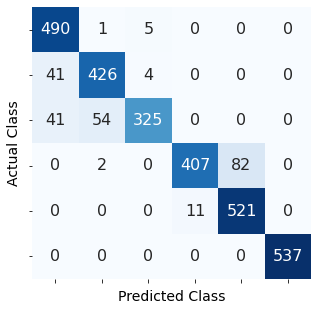

In [173]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_mtx(cm, [], binary = False, figsize = (5,5))

In [174]:
print(classification_report(y_test, y_pred, target_names = activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.86      0.99      0.92       496
  WALKING_UPSTAIRS       0.88      0.90      0.89       471
WALKING_DOWNSTAIRS       0.97      0.77      0.86       420
           SITTING       0.97      0.83      0.90       491
          STANDING       0.86      0.98      0.92       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.92      2947
         macro avg       0.92      0.91      0.91      2947
      weighted avg       0.92      0.92      0.92      2947



In [175]:
knn_tuned_accuracy = accuracy_score(y_test, y_pred)
knn_tuned_accuracy

0.9182219205972175

In [176]:
grid_search_knn.best_score_

0.9076218702288271

# Comparison

In [280]:
def plot_multiclass_roc(clf, X, y, clf_name, ax = None):
    if not isinstance(y, type(np.array([]))):
        y = y.values
    if ax is None:
        fig = plt.figure(figsize = (6, 4))
        ax = fig.add_subplot()
    y_pred_proba = clf.predict_proba(X)   
    for i, label in enumerate(np.unique(y)):
        class_i_arr = (y == label).astype(int)
        class_i_prob_arr = y_pred_proba[:, i]
        RocCurveDisplay.from_predictions(class_i_arr, class_i_prob_arr,
                        name = clf_name + f' of class {label}', ax = ax)
    random = ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), 'k--', 
                 label = 'Random Classifier')
    ax.set_ylabel('True Positive Rate', fontsize = 14)
    ax.set_xlabel('False Positive Rate', fontsize = 14)

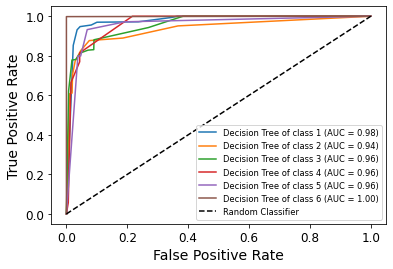

In [283]:
fig, ax = plt.subplots(1,1, figsize = (6, 4))
plot_multiclass_roc(dtc_tuned, X_test, y_test, 
                    'Decision Tree', ax = ax)
ax.legend(fontsize = 'small')
plt.savefig('dtc_multiclass_roc.pdf', bbox_inches = 'tight')
plt.show()

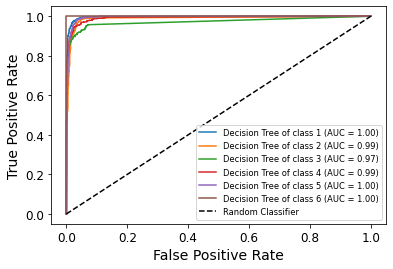

In [284]:
fig, ax = plt.subplots(1,1, figsize = (6, 4))
plot_multiclass_roc(knn_tuned, X_test, y_test, 
                    'Decision Tree', ax = ax)
ax.legend(fontsize = 'small')
plt.savefig('knn_multiclass_roc.pdf', bbox_inches = 'tight')
plt.show()